# Differential Operators in Pyxu

The `pyxu.operator.linop.diff`[🔗](../api/operator/linop.html#derivatives)  module defines a set of classes and functions related to derivative operators. 

In the context of inverse problems, derivative operators come handy when the spatial structure of the object or image be reconstructed can be leveraged. For example, common uses of derivatives are when the image is expected to be smooth in one or more directions, or in contrast, when it is  expected to have sharp edges and flat regions. In those cases, the derivative operators are used as part of regularization terms, adding prior knowledge to our solution.

## Partial Derivatives


The most basic differential operator is the `PartialDerivative`[🔗](../api/operator/linop.html#pyxu.operator.PartialDerivative):

$$\frac{\partial^{n}}{\partial x_0^{n_0} \cdots \partial x_{D-1}^{n_{D-1}}}$$

Which when applied to an given signal $\mathbf{f}$, yields:

$$\frac{\partial^{n}}{\partial x_0^{n_0} \cdots \partial x_{D-1}^{n_{D-1}}}\mathbf{f} =\mathbf{D}\mathbf{f}\in \mathbb{R}^{N_0 \times \cdots \times N_{D-1}}$$


Partial derivatives in `Pyxu` are computed via efficient **matrix-free** implementation, which is based on [JIT compiled stencils](https://numba.pydata.org/numba-doc/latest/user/stencil.html). For illustrative purposes, consider the following approximation to the partial derivatives:


$$\mathbf{D} f [n] = f[n+1] - f[n]$$


As we will see below, this is the forward finite difference approximation. This could be implemented in **matrix-form**, in which case it would look like this:

<center>
<img src="../_static/matrix-form.png" width=400>
</center>

Or, it could be instead implemented via a for loop, in which the case of large input signals, would not require storing a large matrix:

In [1]:
import numpy as np

def D(f):
    """
    Computes the partial derivative via forward finite differences.
    
    Input
    -----
    f: vector
        Input signal
    
    Output
    ------
    y: vector
        Derivative
    """
    
    y = np.zeros_like(f)
    for n in range(len(f) - 1):
        y[n] = f[n + 1] - f[n]
    return y



Despite Python being very slow when it comes to for-loops, Pyxu leverages existing tools to run them efficiently (see [HPC Features](./hpc.ipynb)).

<!---
finite_difference = PartialDerivative.finite_difference(
            arg_shape=(10,), 
            order=(1, ),
            scheme="forward", 
            accuracy=1,)
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(finite_difference.asarray(), cmap="RdYlBu")
ax.set_xticks(np.arange(cut - 1) + 0.5, [])
ax.set_yticks(np.arange(cut - 1) + 0.5, [])
ax.grid(linewidth=3, color="white")
ax.set_title("Finite difference operator (matrix-form)")
plt.colorbar(im, ax=ax)
fig.tight_layout()
fig.savefig("data/images/matrix-form.png", dpi=200)
--->

### Partial Derivative Parametrization

The `PartialDerivative` class implements two main approximations to the partial derivatives as methods:`finite_difference` and `gaussian_derivative`. The common arguments are:

         
- `dim_shape`: Shape of the input image.
- `order`: Derivative order in each axis. For example, for a 2D image input: 
    - `order=(1, 2)` would yield: $\frac{\partial^{3} \mathbf{f}}{\partial x \partial y^{2}}$
    - `order=(2, 0)` would yield: $\frac{\partial^{2} \mathbf{f}}{\partial x^{2}}$

- `mode`: Padding mode to define boundary conditions. Pre-padding and post-trimming are computed to yield an output array of the same shape as the input. It can be defined in general (with a `string`) or per axis (with a `tuple`). The available modes are: 
    - 'constant'
    - 'wrap' 
    - 'reflect'
    - 'symmetric'
    - 'edge' 
    
- `gpu`: Whether the differential operator is meant for GPU or CPU computation.
- `dtype`: Desired precision of computation (single precision is faster than double)
- `sampling`: Spacing between pixels. It can be defined in general (with a `float/int`) or per axis (with a `tuple`)
        
        
The sections below it is explained the differences between these two methods and their specific arguments.

<div class="alert alert-block alert-warning">  
<b>Important:</b> Differential operators are not backend nor dtype agnostic! The arguments `gpu` and `dtype` must be chosen adequately.
</div>


### Finite Differences Approximation to the Partial Derivative

Finite differences approximate the derivatives by computing the difference between pixel values in the image. There are different variations of finite differences, such as forward differences, backward differences, and central differences.

* *Forward Differences*: $\mathbf{D}_{F} f [n] = \frac{f[n+1] - f[n]}{h}$
* *Backward Differences*: $\mathbf{D}_{B} f [n] = \frac{f[n] - f[n-1]}{h}$
* *Central Differences*: $\mathbf{D}_{C} f [n] = \frac{f[n+1] - f[n-1]}{2h}$

Another important parameter for finite difference is the accuracy, which defines the number of digits used for the approximation. 

These are some kernels generated by different parameterizations: the (parenthesis) indicates the central element.


| **Accuracy** |                  _Forward_                  |                 _Backward_                 |            _Central_            |
|:------------:|:-------------------------------------------:|:------------------------------------------:|:-------------------------------:|
|      _1_     |                 [**-1**, 1]                 |                 [-1, **1**]                |                                 |
|      _2_     |             [**-3/2**, 2, -1/2]             |             [1/2, -2, **3/2**]             |        [-1/2, **0**, 1/2]       |
|      _4_     | [ **-25/12** , 48/12, -36/12, 16/12, -3/12] | [ **3/12** , -16/12, 36/12, -48/12, 25/12] | [1/12, -2/3, **0**, 2/3, -1/12] |

Where the coefficients in **bold** indicate the center of the kernel. You can explore different parametrizations with the [finite difference coefficient calculator](https://web.media.mit.edu/~crtaylor/calculator.html), or you can directly create different instantiations and check the coefficients with the `PartialDerivative.visualize()` method.



Finite differences are simple to compute and do not require any additional assumptions or pre-processing steps:

In [2]:
import matplotlib.pyplot as plt
import numpy as np

rng = np.random.default_rng(0)

from pyxu.operator import PartialDerivative

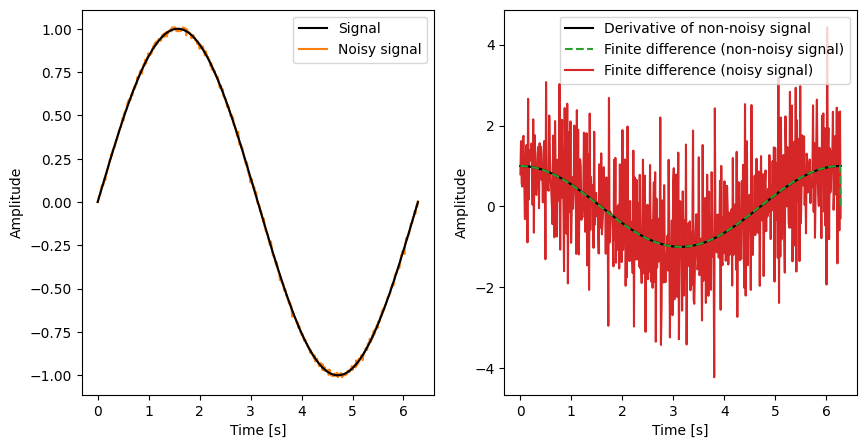

In [3]:
# 1) Define ground truth signal

N = 500  # number of points
x_ax = np.linspace(0, 2 * np.pi, N)  # coordinates
dx = x_ax[1] - x_ax[0]  # sampling or pixel size

arr = np.sin(x_ax)  # ground truth signal
derivative = np.cos(x_ax)  # ground truth derivative


# 2) Define noisy measurements
noise = rng.normal(scale=0.01, size=N)
arr_noisy = arr + noise


# 3) Instantiate partial derivative operator via finite differences
finite_difference = PartialDerivative.finite_difference(
    dim_shape=(N,),
    order=(1,),
    scheme="forward",
    accuracy=1,
    sampling=dx,  # we should include the pixel size for accurate approximation
)

# 4) Estimate derivative
derivative_fd = finite_difference(arr)
derivative_fd_noisy = finite_difference(arr_noisy)

# 5) Plot results

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(x_ax, arr, label="Signal", c="k")
axs[0].plot(x_ax, arr_noisy, label="Noisy signal", zorder=0, c="C1")

axs[1].plot(x_ax, derivative, label="Derivative of non-noisy signal", c="k")
axs[1].plot(
    x_ax, derivative_fd, ls="--", label="Finite difference (non-noisy signal)", c="C2"
)
axs[1].plot(
    x_ax,
    derivative_fd_noisy,
    label="Finite difference (noisy signal)",
    zorder=0,
    c="C3",
)

for ax in axs.ravel():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.legend();

These results indicate that finite differences work fine for non-noisy data, but they can be quite **sensitive to noise** in the image and may introduce inaccuracies, especially when the image has high-frequency content. For more detailed information on this topic, check [this great post on Gaussian derivative](https://www.crisluengo.net/archives/22/).

### Gaussian Derivative Approximation to the Partial Derivative

The Gaussian derivative is an alternative method for estimating partial derivatives. It is derived by **convolving a signal with a Gaussian kernel and then computing the derivatives** of the resulting smoothed signal.


In [4]:
gaussian_derivative = PartialDerivative.gaussian_derivative(
    dim_shape=(N,), order=(1,), sigma=dx, truncate=1, sampling=(dx,)
)
gaussian_derivative.visualize()

'[-21.766068359509617 (0.0) 21.766068359509617]'


The main idea behind Gaussian derivative is to smooth the image with a Gaussian filter, which effectively suppresses noise and reduces the impact of high-frequency variations. The derivative of the Gaussian filter is known analitically, thus the Gaussian derivative is not an approximation of the partial derivative, but the exact derivative of the smoothed signal. This fact leads a biased but more robust estimator compared to finite differences.


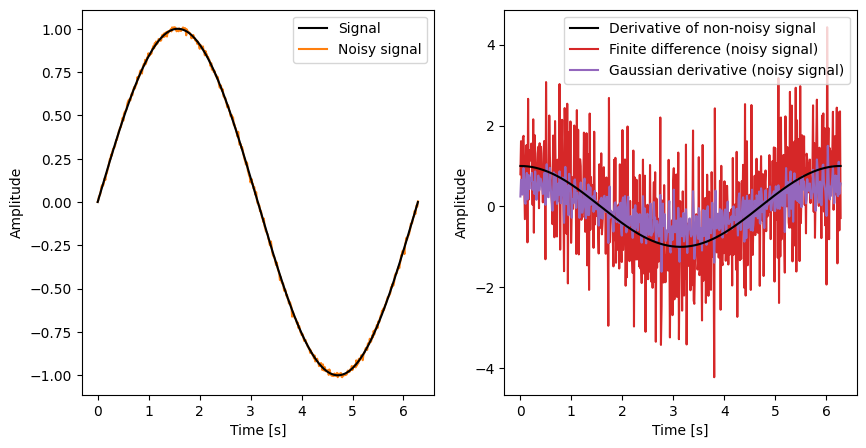

In [5]:
derviative_gd = gaussian_derivative(arr_noisy)
derviative_fd = finite_difference(arr_noisy)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(x_ax, arr, label="Signal", c="k")
axs[0].plot(x_ax, arr_noisy, label="Noisy signal", zorder=0, c="C1")

axs[1].plot(x_ax, derivative, label="Derivative of non-noisy signal", c="k")
axs[1].plot(
    x_ax,
    derivative_fd_noisy,
    label="Finite difference (noisy signal)",
    zorder=0,
    c="C3",
)
axs[1].plot(
    x_ax, derviative_gd, label="Gaussian derivative (noisy signal)", c="C4", zorder=1
)

for ax in axs.ravel():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.legend()

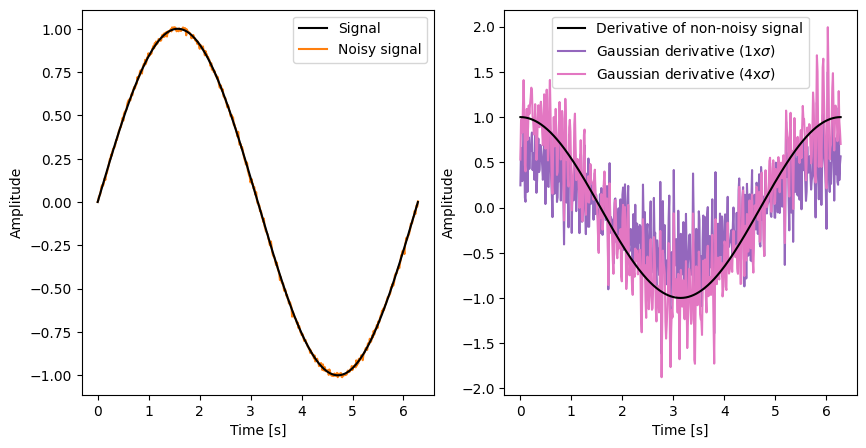

In [6]:
gaussian_derivative_accurate = PartialDerivative.gaussian_derivative(
    dim_shape=(N,), order=(1,), sigma=dx, truncate=4, sampling=(dx,)
)


derviative_gd_accurate = gaussian_derivative_accurate(arr_noisy)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(x_ax, arr, label="Signal", c="k")
axs[0].plot(x_ax, arr_noisy, label="Noisy signal", zorder=0, c="C1")

axs[1].plot(x_ax, derivative, label="Derivative of non-noisy signal", c="k")
axs[1].plot(
    x_ax, derviative_gd, label="Gaussian derivative (1x$\sigma$)", c="C4", zorder=0
)
axs[1].plot(
    x_ax,
    derviative_gd_accurate,
    label="Gaussian derivative (4x$\sigma$)",
    c="C6",
    zorder=1,
)

for ax in axs.ravel():
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.legend()


Gaussian derivatives can be computed for different orders of derivatives (e.g., first-order, second-order) and at different scales (by varying the standard deviation of the Gaussian kernel). Higher-order derivatives capture more detailed information about the image's structure, while larger scales provide a more global representation.

### How to choose between Finite Differences and Gaussian Derivative?

The choice between *finite difference* and *Gaussian derivative* can be seen as a **trade-off between bias and variance**:

* When estimating partial derivatives, the Gaussian derivative robustly captures the true behavior of the derivative of the smoothed signal, thus introducing bias in the estimation. 
* On the other hand, finite differences, especially when using a small accuracy value, can be highly sensitive to noise and can produce unstable estimates of the derivative (variance). Gaussian derivatives, on the other hand, tend to be smoother and less affected by noise.

As a rule of thumb, it is recommended to try both approaches and to use the Gaussian derivative for very noisy signals.

## Stacks of Partial Derivatives

There are two main classes of stacks of partial derivative:

* `Gradient`[🔗](../api/operator/linop.html#pyxu.operator.Gradient): stack of all first order derivatives (one per axis), 


$$\mathbf{f} = \begin{bmatrix}
   \frac{\partial \mathbf{f}}{\partial x_0} \\
   \vdots \\
   \frac{\partial \mathbf{f}}{\partial x_{D-1}}
   \end{bmatrix} \in \mathbb{R}^{D \times N_{0} \times \cdots \times N_{D-1}}$$


* `Hessian`[🔗](../api/operator/linop.html#pyxu.operator.Hessian): stack of all second order derivatives,

$$\mathbf{H} \mathbf{f} = \begin{bmatrix}
   \dfrac{ \partial^{2}\mathbf{f} }{ \partial x_{0}^{2} } &  \dfrac{ \partial^{2}\mathbf{f} }{ \partial x_{0}\,\partial x_{1} } & \cdots & \dfrac{ \partial^{2}\mathbf{f} }{ \partial x_{0} \, \partial x_{D-1} } \\
   \dfrac{ \partial^{2}\mathbf{f} }{ \partial x_{1} \, \partial x_{0} } & \dfrac{ \partial^{2}\mathbf{f} }{ \partial x_{1}^{2} } & \cdots & \dfrac{ \partial^{2}\mathbf{f} }{\partial x_{1} \,\partial x_{D-1}} \\
   \vdots & \vdots & \ddots & \vdots \\
   \dfrac{ \partial^{2}\mathbf{f} }{ \partial x_{D-1} \, \partial x_{0} } & \dfrac{ \partial^{2}\mathbf{f} }{ \partial x_{D-1} \, \partial x_{1} } & \cdots & \dfrac{ \partial^{2}\mathbf{f} }{ \partial x_{D-1}^{2}}
   \end{bmatrix}$$

### Parameters

The `Gradient` and `Hessian` objects share some common arguments that we didn't see in the previous `PartialDerivative` class:
        
* `diff_method`: This will select between `finite_difference` ('fd') or `gaussian_derivative` ('gd') type of partial derivatives.
* `diff_kwargs`: Placeholder to specify arguments that are specific to `finite_difference` and `gaussian_derivative`.
        
The sections below it is explained the differences between these two methods and their specific arguments.

<div class="alert alert-block alert-warning">  
<b>Important:</b> Be aware that the `directions` argument has different behavior between `Gradient` and `Hessian`. Keep reading for further details.
</div>


### Gradient

The gradient operator applies the first-order derivatives on all dimensions if the signal and concatenates them. 

For example, in the case of a 2-dimensional image, the gradient operator implements:

$$\boldsymbol{\nabla} \mathbf{f} = \begin{bmatrix}
    \frac{\partial \mathbf{f}}{\partial x} \\
    \frac{\partial \mathbf{f}}{\partial y}
    \end{bmatrix} \in \mathbb{R}^{2 \times N_{x} \times N_{y}}$$



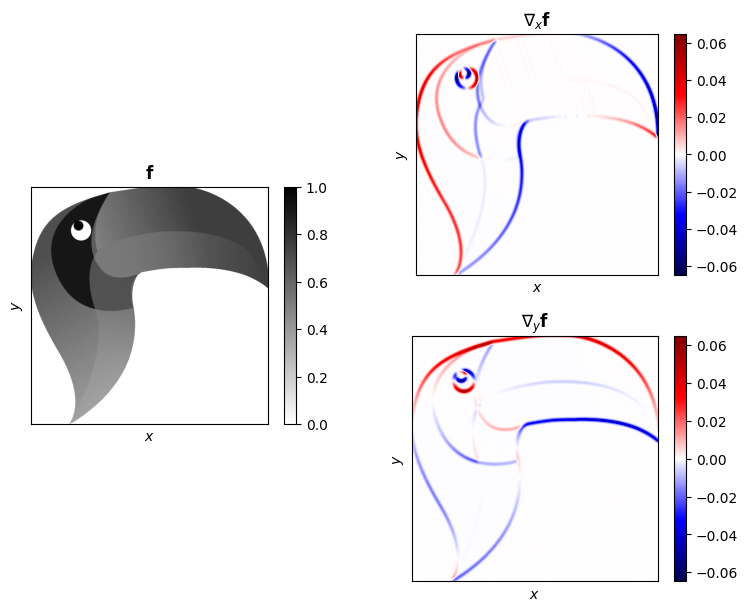

In [7]:
from PIL import Image
from pyxu.operator import Gradient

toucan = np.array(Image.open("../_static/favicon.png").convert("L"))
toucan = toucan.astype(float)
toucan /= toucan.max()

grad = Gradient(
    dim_shape=toucan.shape,
    diff_method="gd",
    sigma=6,
)

out = grad(toucan)

# Plot
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 2)
axs = [
    fig.add_subplot(gs[1:-1, 0]),
    fig.add_subplot(gs[:2, 1]),
    fig.add_subplot(gs[2:, 1]),
]
im = axs[0].imshow(toucan, cmap="gray_r")
axs[0].set_title(r"$\mathbf{f}$")
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(
    out[1], cmap="seismic", vmin=-np.max(np.abs(out[1])), vmax=np.max(np.abs(out[1]))
)
axs[1].set_title(r"$\nabla_{x}\mathbf{f}$")
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(
    out[0], cmap="seismic", vmin=-np.max(np.abs(out[0])), vmax=np.max(np.abs(out[0]))
)
axs[2].set_title(r"$\nabla_{y}\mathbf{f}$")
plt.colorbar(im, ax=axs[2])

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")



                                                                              ┌───>  Jacobian
                                                ┌───>   Gradient (order=1)  ──┴───>  Divergence
                      PartialDerivative   ──────┤
                                                └───>   Hessian  (order=2)  ──────>  Laplacian

### Hessian

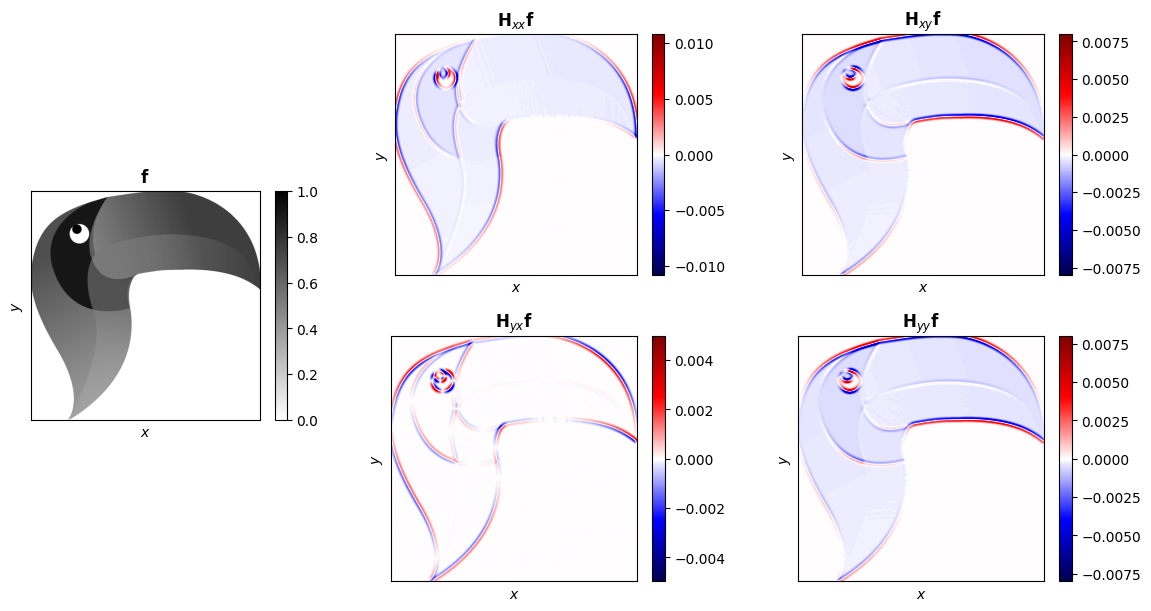

In [8]:
from pyxu.operator import Hessian

hes = Hessian(
    dim_shape=toucan.shape,
    diff_method="gd",
    sigma=6,
)

out = hes(toucan)

# Plot
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(4, 3)
axs = [
    fig.add_subplot(gs[1:-1, 0]),
    fig.add_subplot(gs[:2, 1]),
    fig.add_subplot(gs[2:, 1]),
    fig.add_subplot(gs[:2, 2]),
    fig.add_subplot(gs[2:, 2]),
]
im = axs[0].imshow(toucan, cmap="gray_r")
axs[0].set_title(r"$\mathbf{f}$")
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(
    out[2], cmap="seismic", vmin=-np.max(np.abs(out[2])), vmax=np.max(np.abs(out[2]))
)
axs[1].set_title(r"$\mathbf{H}_{xx}\mathbf{f}$")
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(
    out[1], cmap="seismic", vmin=-np.max(np.abs(out[1])), vmax=np.max(np.abs(out[1]))
)
axs[2].set_title(r"$\mathbf{H}_{yx}\mathbf{f}$")
plt.colorbar(im, ax=axs[2])
im = axs[3].imshow(
    out[0], cmap="seismic", vmin=-np.max(np.abs(out[0])), vmax=np.max(np.abs(out[0]))
)
axs[3].set_title(r"$\mathbf{H}_{xy}\mathbf{f}$")
plt.colorbar(im, ax=axs[3])
im = axs[4].imshow(
    out[0], cmap="seismic", vmin=-np.max(np.abs(out[0])), vmax=np.max(np.abs(out[0]))
)
axs[4].set_title(r"$\mathbf{H}_{yy}\mathbf{f}$")
plt.colorbar(im, ax=axs[4])

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")